In [1]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (13, 5)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.ensemble import RandomForestClassifier


In [2]:
features = pd.read_csv('data/fma_metadata/df_senzaOutliers.csv',index_col=[0], header=[0,1,2])

features

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   
...                ...        ...        ...         ...        ...   
155297        0.408626   3.826046  94.208336   48.085751  26.723190   
155298        0.439034 -72.790154  81.013275  124.569000  29.571426   
155306        0.369401  -7.814734  88.024063  116.180260  29.388819   
155307        0.357939 -13.889938  62.219879   93.028778  41.311356   
155314        0.551894 -15.305521  32.737503   95.054657  25.620636   

feature                                                                ...  \
statistics                   mean           min                        ...   
number             11          02            02         04         05  ...   
track_id                                                               ...   
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890  ...   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355  ...   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310  ...   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949  ...   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829  ...   
...               ...         ...           ...        ...        ...  ...   
155297      19.866936  163.954620 -1.776357e-14 -29.221125 -28.104187  ...   
155298      38.472843  160.770218 -7.993606e-14  -7.314378 -69.236115  ...   
155306      47.185654  177.614151  5.329071e-15 -49.451691 -70.841232  ...   
155307      33.690544  124.228142 -5.892177e+00 -50.547176 -99.119080  ...   
155314      34.402496  166.692734 -2.464827e-01 -55.172737 -55.477066  ...   

feature                          spectral_bandwidth spectral_contrast  \
statistics        std                      kurtosis               max   
number             02         04                 01                03   
track_id                                                                
2           38.569584  20.767921           3.874384         39.333603   
3           41.191982  22.025253           2.383340         42.141411   
5           39.367599  24.319347           0.895442         39.017235   
10          44.409843  14.013119           0.437628         45.410881   
134         47.266518  36.841534           0.372903         41.526760   
...               ...        ...                ...               ...   
155297      30.287067  12.060067          20.706787         40.720093   
155298      39.359367  18.604885           5.868375         39.627396   
155306      40.537926  28.671246           4.375974         40.628235   
155307      35.382370  22.123117          -0.383395         48.715477   
155314      26.786989  22.369673           0.011010         39.460281   

feature                           tonnetz metadata                              
statistics                  min       std      set         track                
number             04        02        01   subset     genre_top genre_top_Cat  
track_id                                                                        
2           31.513493  2.296826  0.019809    small       Hip-Hop             7  
3           31.473713  0.652681  0.026316   medium       Hip-Hop             7  
5           33.707951  2.314010  0.025550    small       Hip-Hop             7  
10          28.711344  4.415900  0.021413    small           Pop            12  
134         32.2243

In [3]:
attributes = [col for col in features.columns if (col != ('metadata','track','genre_top') and 
                                                  col != ('metadata','set','subset')  and
                                                 col != ('metadata','track','genre_top_Cat'))] 

X = features[attributes].values
y = features[('metadata','track','genre_top_Cat')]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split' : range(10,70,10),
              'min_samples_leaf' : range(10,70,10),
              'max_depth': range(5, 20, 3),
             'class_weight':['balanced','balanced_subsample'],
             'max_features':['sqrt','log2']
             }


clf1 = RandomizedSearchCV(DecisionTreeClassifier(), 
                         param_grid, cv=StratifiedKFold(5), scoring='f1_macro')

clf1 = clf1.fit(X_train, y_train)
report(clf1.cv_results_, n_top=5)

In [12]:
clf1 = RandomForestClassifier(criterion='gini', max_depth=18, min_samples_split=40, min_samples_leaf=30,
                              class_weight="balanced_subsample",
                             max_features='log2')
clf1 = clf1.fit(X_train, y_train)


In [13]:
y_pred_tr = clf1.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='macro'))
print('Val Recall %s' % recall_score(y_train, y_pred_tr,average='macro'))
print('Val Precision %s' % precision_score(y_train, y_pred_tr,average='macro'))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)


Train Accuracy 0.5747431605679326
Train F1-score 0.5390537832079283
Val Recall 0.7368028939805689
Val Precision 0.4810056916752135
              precision    recall  f1-score   support

           0       0.40      1.00      0.57        52
           1       0.43      0.91      0.58       433
           2       0.35      0.98      0.51       125
           3       0.56      1.00      0.71        15
           4       0.77      0.49      0.60      4367
           5       0.57      0.20      0.30      1507
           6       0.49      0.67      0.56      1061
           7       0.46      0.73      0.57      1538
           8       0.42      0.50      0.45       926
           9       0.48      0.55      0.51       709
          10       0.30      0.76      0.43       267
          11       0.72      0.99      0.83       351
          12       0.42      0.40      0.41       827
          13       0.76      0.64      0.70      4959
          14       0.37      0.98      0.54       108
    

array([[  52,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,  393,    0,    1,    2,    2,    7,    0,    9,    2,    9,
           3,    2,    2,    0,    1],
       [   0,    0,  122,    0,    0,    0,    1,    0,    1,    0,    0,
           0,    0,    0,    0,    1],
       [   0,    0,    0,   15,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  22,  101,   24,    6, 2134,   84,  135,  685,  199,  113,  158,
          19,  123,  383,  114,   67],
       [   8,  140,    7,    2,  161,  306,   89,  105,  153,   73,   66,
          49,   51,  210,   15,   72],
       [   3,   31,   20,    0,   16,   11,  706,   29,   59,   45,   38,
          10,   24,   61,    1,    7],
       [   1,    2,   10,    0,  116,   11,   26, 1119,   16,   12,   10,
           0,   26,  116,   19,   54],
       [   3,  165,    1,    0,   32,   25,   57,   19,  462,   12,   26,
          19,   21,   

In [14]:
y_pred = clf1.predict(X_test)

print('Val Accuracy %0.4f' % accuracy_score(y_test, y_pred))


print('Train F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print('Val Recall %s' % recall_score(y_test, y_pred,average='macro'))
print('Val Precision %s' % precision_score(y_test, y_pred,average='macro'))

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Val Accuracy 0.4848
Train F1-score 0.3309765444647724
Val Recall 0.41289118627073673
Val Precision 0.31543871786036226
              precision    recall  f1-score   support

           0       0.07      0.18      0.10        22
           1       0.40      0.83      0.54       185
           2       0.12      0.36      0.18        53
           3       0.00      0.00      0.00         6
           4       0.68      0.45      0.54      1871
           5       0.43      0.13      0.20       646
           6       0.42      0.55      0.48       455
           7       0.39      0.67      0.49       659
           8       0.36      0.39      0.37       397
           9       0.30      0.33      0.31       304
          10       0.12      0.29      0.16       115
          11       0.72      0.95      0.82       151
          12       0.14      0.11      0.12       355
          13       0.71      0.61      0.66      2126
          14       0.07      0.17      0.10        46
          15    

array([[   4,    2,    0,    0,    2,    1,    1,    1,    1,    6,    0,
           0,    2,    2,    0,    0],
       [   0,  154,    0,    0,    1,    2,    6,    1,    9,    1,    5,
           1,    0,    1,    0,    4],
       [   1,    0,   19,    0,    0,    2,    7,    4,    0,    4,    0,
           1,    3,   12,    0,    0],
       [   0,    1,    0,    0,    1,    0,    0,    2,    0,    1,    0,
           0,    1,    0,    0,    0],
       [  15,   43,   14,    1,  839,   34,   41,  351,   82,   45,   68,
           8,   60,  173,   69,   28],
       [   6,   45,   10,    2,   89,   85,   48,   41,   64,   28,   48,
          18,   20,   99,    4,   39],
       [   1,   19,   16,    0,    8,    8,  252,   15,   29,   19,   23,
           3,   22,   35,    1,    4],
       [   2,    0,    7,    0,   84,    4,    9,  440,    3,    9,    4,
           1,   15,   48,   13,   20],
       [   2,   65,    0,    1,   20,   15,   31,    8,  156,    8,   32,
          10,    9,   

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[   4    2    0    0    2    1    1    1    1    6    0    0    2    2
     0    0]
 [   0  154    0    0    1    2    6    1    9    1    5    1    0    1
     0    4]
 [   1    0   19    0    0    2    7    4    0    4    0    1    3   12
     0    0]
 [   0    1    0    0    1    0    0    2    0    1    0    0    1    0
     0    0]
 [  15   43   14    1  839   34   41  351   82   45   68    8   60  173
    69   28]
 [   6   45   10    2   89   85   48   41   64   28   48   18   20   99
     4   39]
 [   1   19   16    0    8    8  252   15   29   19   23    3   22   35
     1    4]
 [   2    0    7    0   84    4    9  440    3    9    4    1   15   48
    13   20]
 [   2   65    0    1   20   15   31    8  156    8   32   10    9   36
     2    2]
 [   3   10   10    0   34    3   27   44    5   99   10    5    7   34
     5    8]
 [   2    7    1    0   14    0   14    7   15    5   33    1    5   10
     0    1]
 [   0    4    0    0    

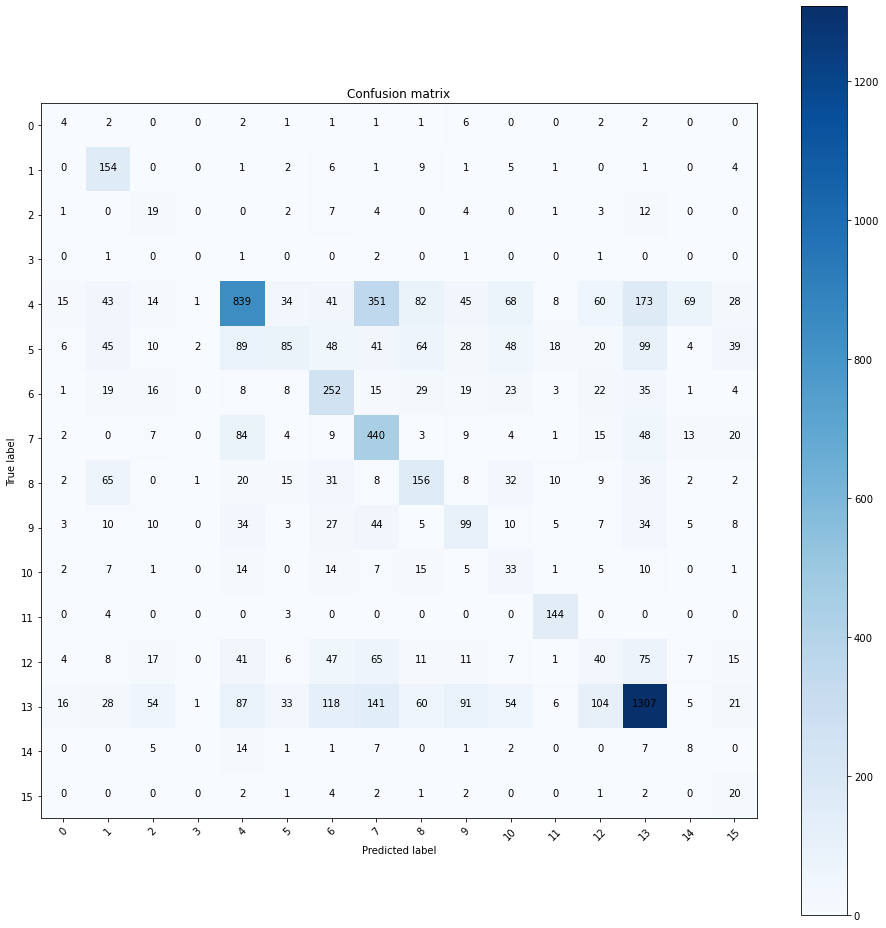

In [16]:
plt.rcParams['figure.figsize'] = (13, 13)

cm1=confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm1, classes=clf1.classes_,
                      title='Confusion matrix')



plt.show()